# Create infrastructure maps

## imports

In [71]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely import Point

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import os

In [ ]:


import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

import shapely.geometry
import shapely.ops
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import rasterio
from rasterio.features import shapes
from shapely.geometry import shape

from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio import features
from rasterio.plot import show, plotting_extent
from matplotlib.markers import MarkerStyle

from osgeo import gdal, ogr

from scipy.ndimage import maximum_filter

import plotly.express as px

### Settings

In [107]:
# list of scenarios for analysis
scenario_list = ['net_zero_ira_ccs_climate', 'business_as_usual_ira_ccs_climate']

# list of years for analysis
year_list = list(range(2025, 2035+1, 5))

# coordinates and labels for specified cities
city_label_data = {
    'city': ['Albuquerque', 'San Francisco', 'Los Angeles', 'Portland', 'Seattle', 'Phoenix', 'Salt Lake City', 'Denver', 'Boise', 'Boulder', 
             "Grand Junction", "Billings", "Cheyenne", "Las Vegas"], 
    'Latitude': [35.0853336,  37.7749295, 34.0522342, 45.5230622, 47.6062095, 33.4483771, 40.7607793, 39.7392358, 43.6187102, 40.0149856, 
                 39.0638705, 45.7832856, 41.1399814,  36.1699412],  
    'Longitude': [-106.6055534, -122.4194155,  -118.2436849, -122.6764816, -122.3320708,-112.0740373,-111.8910474, -104.990251, -116.2146068, 
                  -105.2705456, -108.5506486, -108.5006904,-104.8202462, -115.1398296]}

retired_color = '#631200'

color_map_dict={
    'Natural Gas':'#bdb59d',
    'Coal': '#75736d',
    'Solar PV': '#F7B615',
    'Solar CSP': '#f1781b',
    'Wind': '#95C060', 
    'Nuclear': '#6D547C', 
    'Offshore Wind':'#2B7F9E', 
    'Biomass': '#713275',
    'Geothermal': '#BB3B1C', 
    'Oil': '#BB3B1C',
    'Hydro': '#14345e'}

markersize = 8

# create map legend elements
natgas = Line2D([0], [0], lw=0, markersize=markersize, label='Natural Gas',marker='o', markerfacecolor=color_map_dict['Natural Gas'], markeredgecolor=color_map_dict['Natural Gas'])
solar_pv = Line2D([0], [0], lw=0, markersize=markersize, label='Solar PV',marker='o', markerfacecolor=color_map_dict['Solar PV'], markeredgecolor=color_map_dict['Solar PV'])
solar_csp = Line2D([0], [0], lw=0, markersize=markersize, label='Solar CSP',marker='o', markerfacecolor=color_map_dict['Solar CSP'], markeredgecolor=color_map_dict['Solar CSP'])
wind = Line2D([0], [0], lw=0, markersize=markersize,label='Wind',marker='o', markerfacecolor=color_map_dict['Wind'], markeredgecolor=color_map_dict['Wind'])
wind_off = Line2D([0], [0], lw=0, markersize=markersize, label='Offshore Wind',marker='o', markerfacecolor=color_map_dict['Offshore Wind'], markeredgecolor=color_map_dict['Offshore Wind'])
coal= Line2D([0], [0], lw=0, markersize=markersize, label='Coal',marker='o', markerfacecolor=color_map_dict['Coal'], markeredgecolor=color_map_dict['Coal'])
biomass = Line2D([0], [0], lw=0, markersize=markersize, label='Biomass',marker='o', markerfacecolor=color_map_dict['Biomass'], markeredgecolor=color_map_dict['Biomass'])
geothermal = Line2D([0], [0], lw=0, markersize=markersize, label='Geothermal',marker='o', markerfacecolor=color_map_dict['Geothermal'], markeredgecolor=color_map_dict['Geothermal'])
hydro = Line2D([0], [0], lw=0, markersize=markersize, label='Hydro',marker='o', markerfacecolor=color_map_dict['Hydro'], markeredgecolor=color_map_dict['Hydro'])

retired = Line2D([0], [0], lw=0, markersize=markersize, label='Retired Power Plants',marker='x', color=retired_color)
volt = Line2D([0], [0], color='black', lw=1, label='Transmission >250kV')

legend_elements = [coal, natgas, biomass, geothermal,solar_csp, solar_pv, wind, wind_off, hydro, retired, volt]


### Collect Data Paths

In [111]:
# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

# output figure dir
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'figures')

# western interconnection shapefile
wecc_shp_path =  os.path.join(data_dir, "wecc_boundary_shp", "wecc_boundary.shp")

# western interconnection transmission shapefile
transmission_path = os.path.join(data_dir, 'transmission_shp', 'wecc_transmission_250kv.shp')

# infrastructure siting output csv
infrastucture_path = os.path.join(data_dir, 'infrastructure_data_csv', 'infrastructure_data.csv')

### Functions

In [116]:
def results_to_geodataframe(df, crs = "ESRI:102003"):
    """ 
    Takes a pandas DataFrame with x and y coordinates as input and 
    converts to a GeoPandas GeodataFrame. Coordinates in DataFrame are expected to
    follow the ESRI:102003 albers equal area conic coordinate referece system.
    x-coordinate column should be called 'xcoord', y-coordinate column should be
    called 'ycoord'

    :param df:        input Pandas DataFrame with x/y coordinates
    :type df:         Pandas DataFrame
    
    :param crs:       Coordinate reference system to use for GeoDataFrame
    :type crs:        str
    
    """
    
    # create geometry column from coordinate fields
    geometry = [Point(xy) for xy in zip(df['xcoord'], df['ycoord'])]
    
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return gdf


def plot_map(gdf, scenario, city_gdf, year, title, output_file_name, all_operational=False):
    """
    Maps power plant sitings for given scenario and run year. All CERF-sited power plants by
    given run year will be sited along with all power plants that were retired up to the same year.
    If the all_operational parameter is set to True, this function will also plot all power plants
    that are operational in the given year, both CERF-sited and non CERF-sited (i.e., pre-existing infrastructure.
    The resulting map is save as a png file to the figures folder.

    :param gdf:                       Geopandas GeoDataFrame of power plants (new cerf sited, non-cerf sited operational, and non-cerf sited retired)
    :type gdf:                        geopandas.GeoDataFrame
    
    :param scenario:                  Name of scenario to plot
    :type scenario:                   str

    :param city_gdf:                  Geopandas GeoDataFrame of major city locations
    :type city_gdf:                   geopandas.GeoDataFrame

    :param year:                      Year that values should be plotted for
    :type year:                       int  

    :param title:                     Plot title
    :type title:                      str  

    :param output_file_name:          Name of file to save output image as
    :type output_file_name:           str  

    :param all_operational:           If True, all operational plants are plotted. If False, only new infrastructure and retired plants are plotted.
    :type all_operational:            bool     

    """
    
    # set figure size
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_axis_off();

    # plot wecc boundary
    wecc_shp.boundary.plot(ax=ax, color = 'black')

    # plot cerf-sited plants
    gdf_cerf = gdf[(gdf.cerf_sited == 1) & (gdf.scenario == scenario)]
    gdf_cerf.plot(ax=ax, markersize=12,  marker = 'o', lw=.3, facecolor=gdf_cerf['tech_name_simple'].map(color_map_dict))

    # plot retired plants
    gdf[(gdf.retirement_year <= year) & (gdf.scenario == scenario)].plot(ax=ax, markersize=25, color=retired_color, marker="x")

    if all_operational:
        gdf_op = gdf[(gdf.retirement_year > year) & (gdf.scenario == scenario) & (gdf.cerf_sited == 0)].copy()
        gdf_op.plot(ax=ax, markersize=12,  marker = 'o', lw=.3, facecolor=gdf_op['tech_name_simple'].map(color_map_dict))
    else:
        pass
    
    # plot transmission line
    transmission_shp.plot(ax=ax, color='black', lw=.75)

    # plot city locations
    city_gdf.plot(ax=ax, color='black')

    # add city labels
    for x, y, label in zip(city_gdf.geometry.x, city_gdf.geometry.y, city_gdf.city):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", ha='right', size=12)

    # add legend
    plt.legend(handles=legend_elements, fontsize=12, title_fontsize = 12, loc='lower left', ncol=1, facecolor='white')

    # add title
    plt.title(title, size=20)

    # save figure to folder
    plt.savefig(os.path.join(fig_dir, output_file_name))
    
    return plt.show()

### Collect Data

In [79]:
# read in wecc shapefile
wecc_shp = gpd.read_file(wecc_shp_path)

# read in wecc transmission shapefile
transmission_shp = gpd.read_file(transmission_path)

# collect infrastructure data
df = pd.read_csv(infrastucture_path)

### Create Geodataframes

In [83]:
# create geodataframe from infrastucture data
gdf = results_to_geodataframe(df=df)

# create a geodataframe of major cities to plot
city_df = pd.DataFrame.from_dict(city_label_data)
city_gdf = gpd.GeoDataFrame(city_df, geometry=gpd.points_from_xy(city_df.Longitude, city_df.Latitude), crs="EPSG:4326")
city_gdf.to_crs('ESRI:102003', inplace=True)

### Create Maps

#### Clean Grid by 2035 - New Power Plant Sitings and Retirements

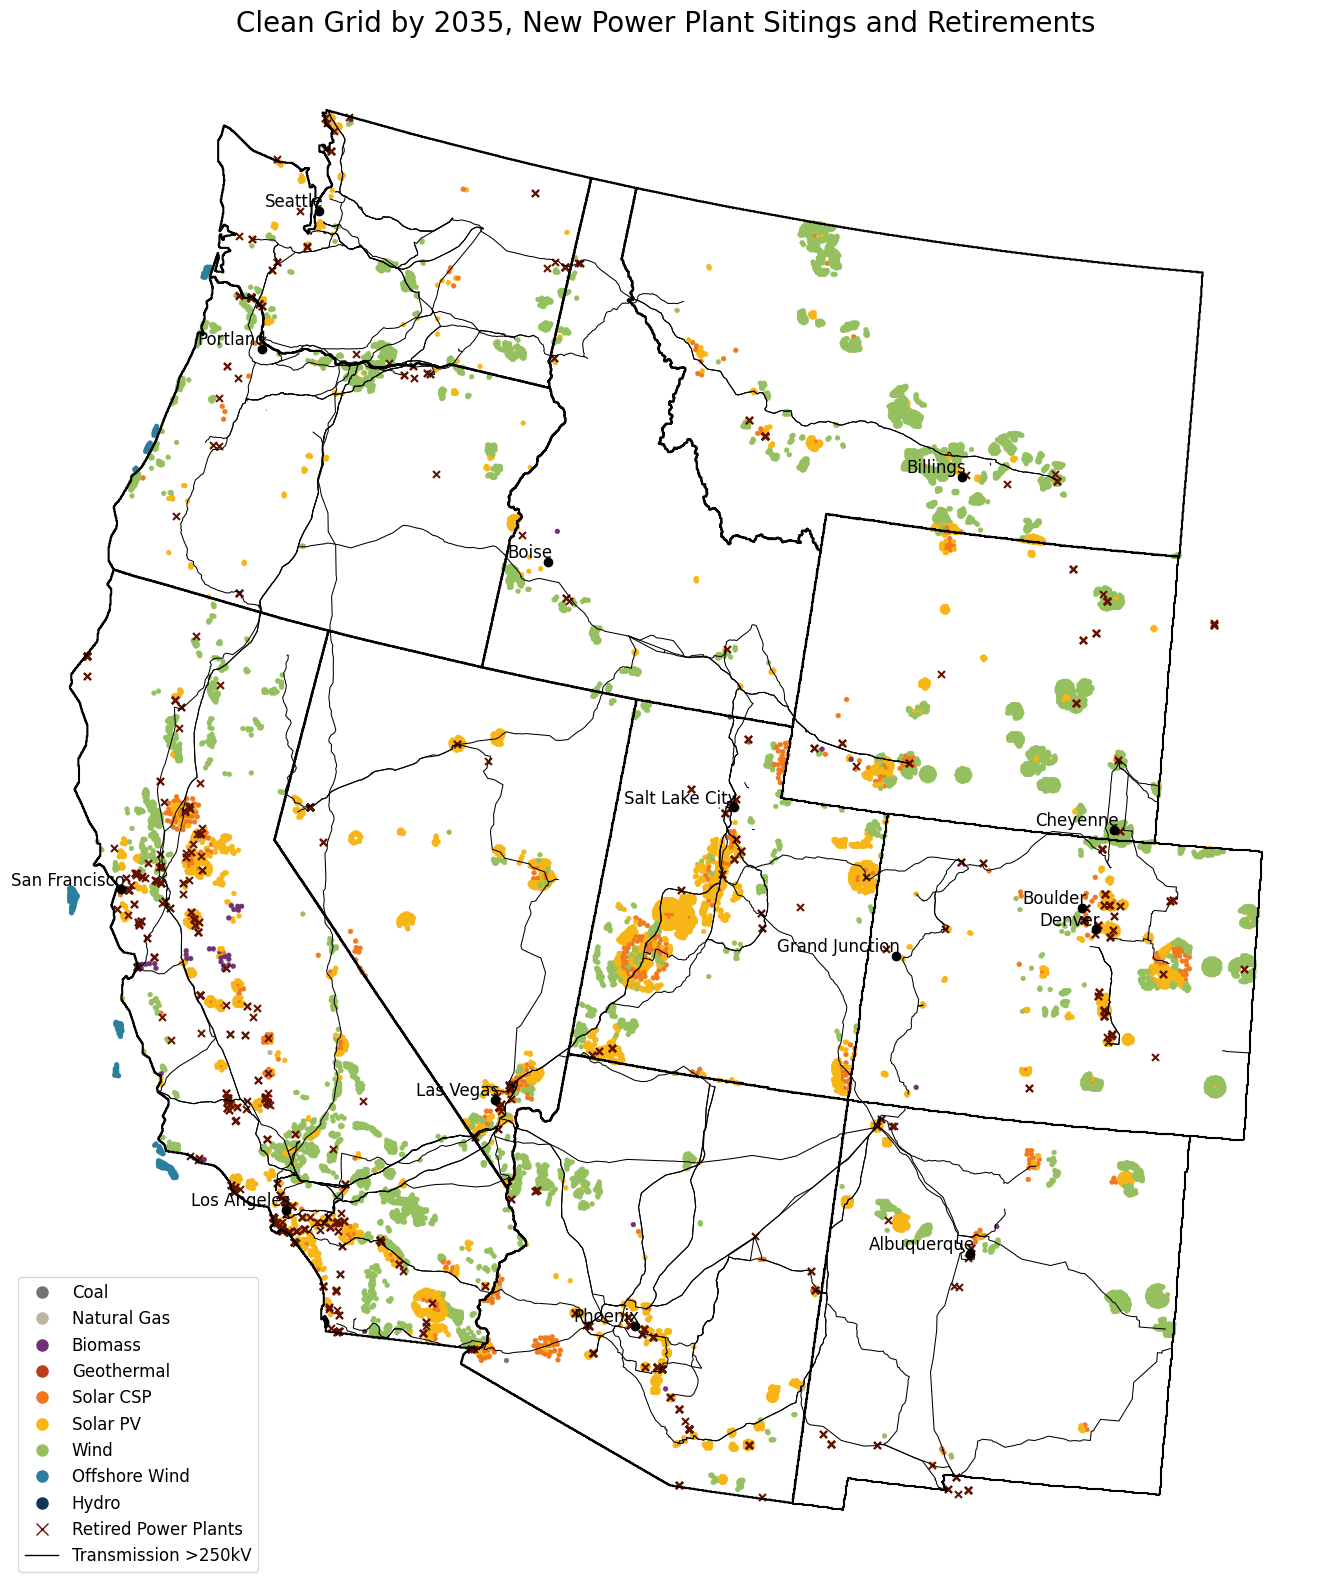

In [117]:
plot_map(gdf=gdf, scenario='net_zero_ira_ccs_climate', city_gdf=city_gdf, year=2035,
         output_file_name = 'map_clean_grid_2035.png',
         all_operational=False, 
         title = 'Clean Grid by 2035, New Power Plant Sitings and Retirements')

#### Clean Grid by 2035 - All Operational + Retirements

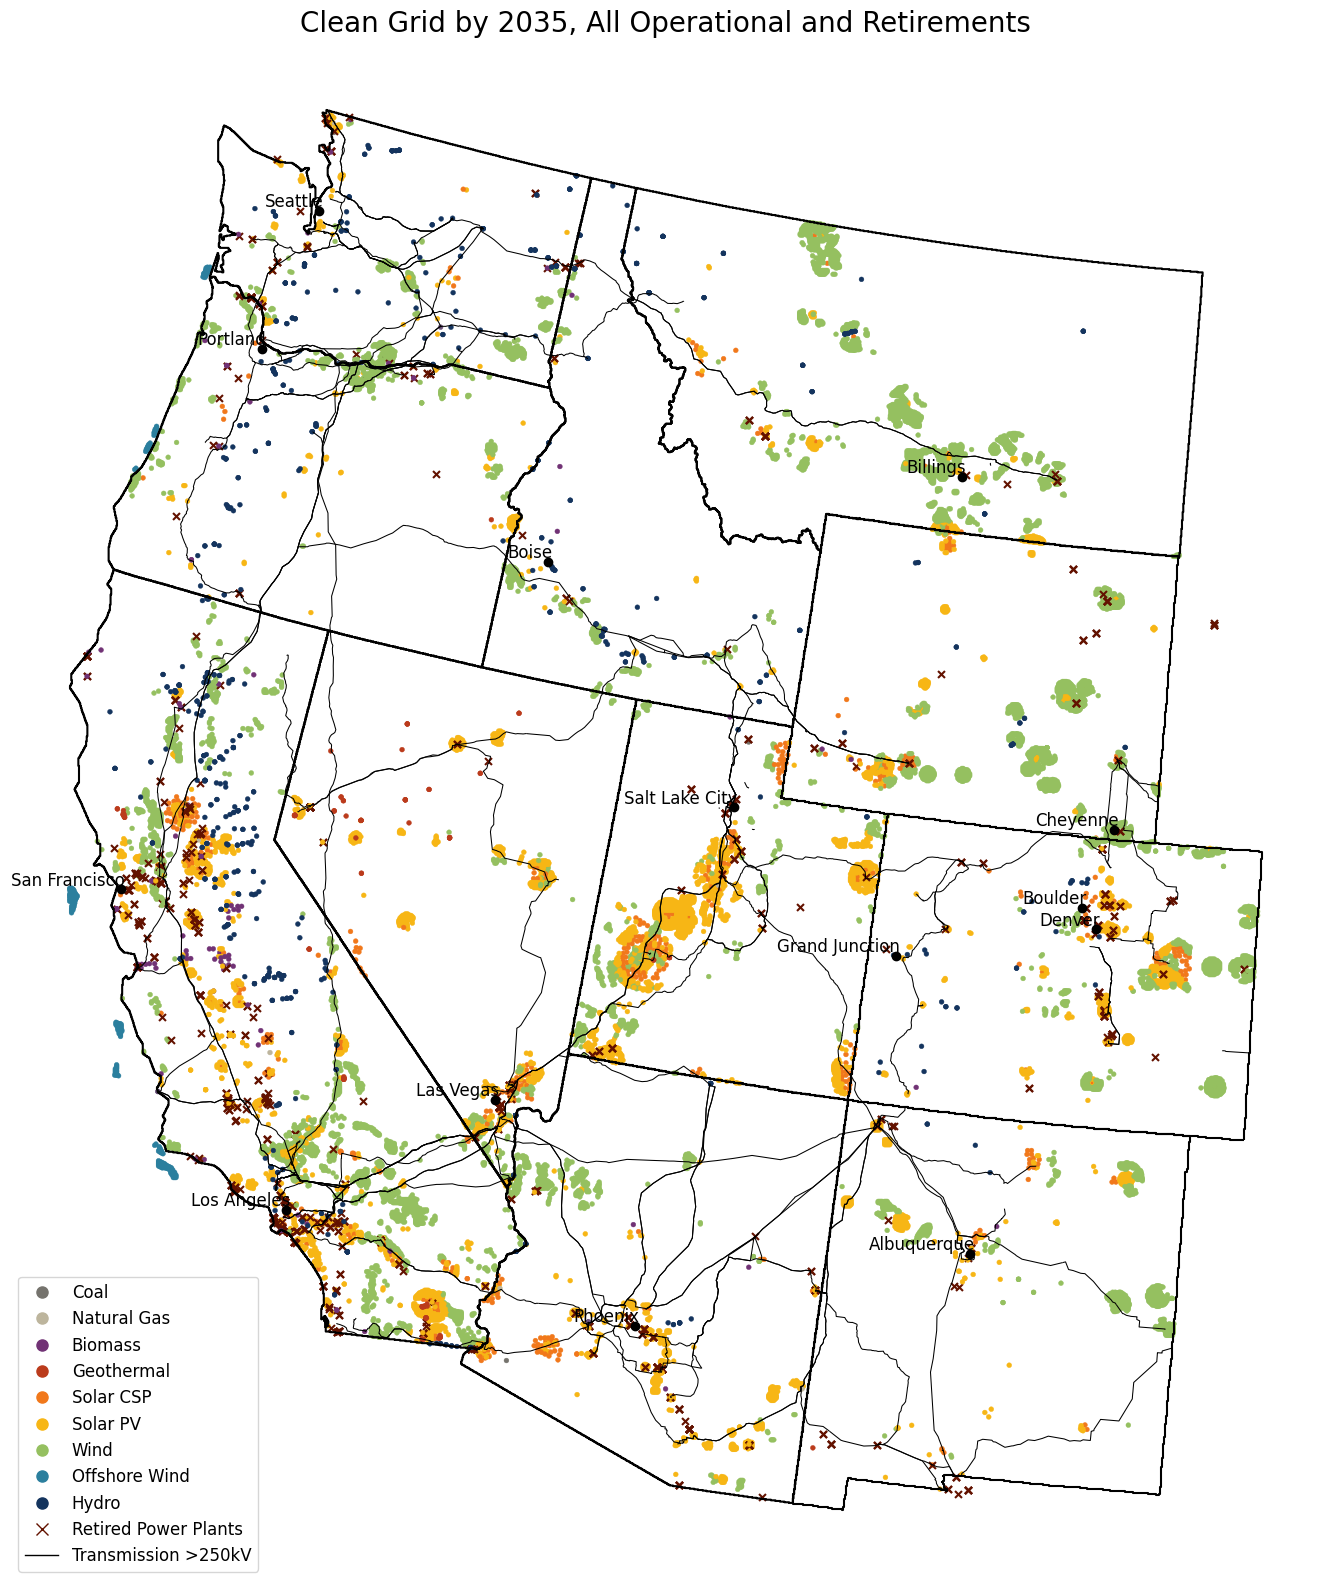

In [118]:
plot_map(gdf=gdf, scenario='net_zero_ira_ccs_climate', city_gdf=city_gdf, year=2035,
         output_file_name = 'map_clean_grid_2035_all_operational.png',
         all_operational=True, 
         title = 'Clean Grid by 2035, All Operational and Retirements')

#### Business-as-usual by 2035 - New Power Plant Sitings and Retirements

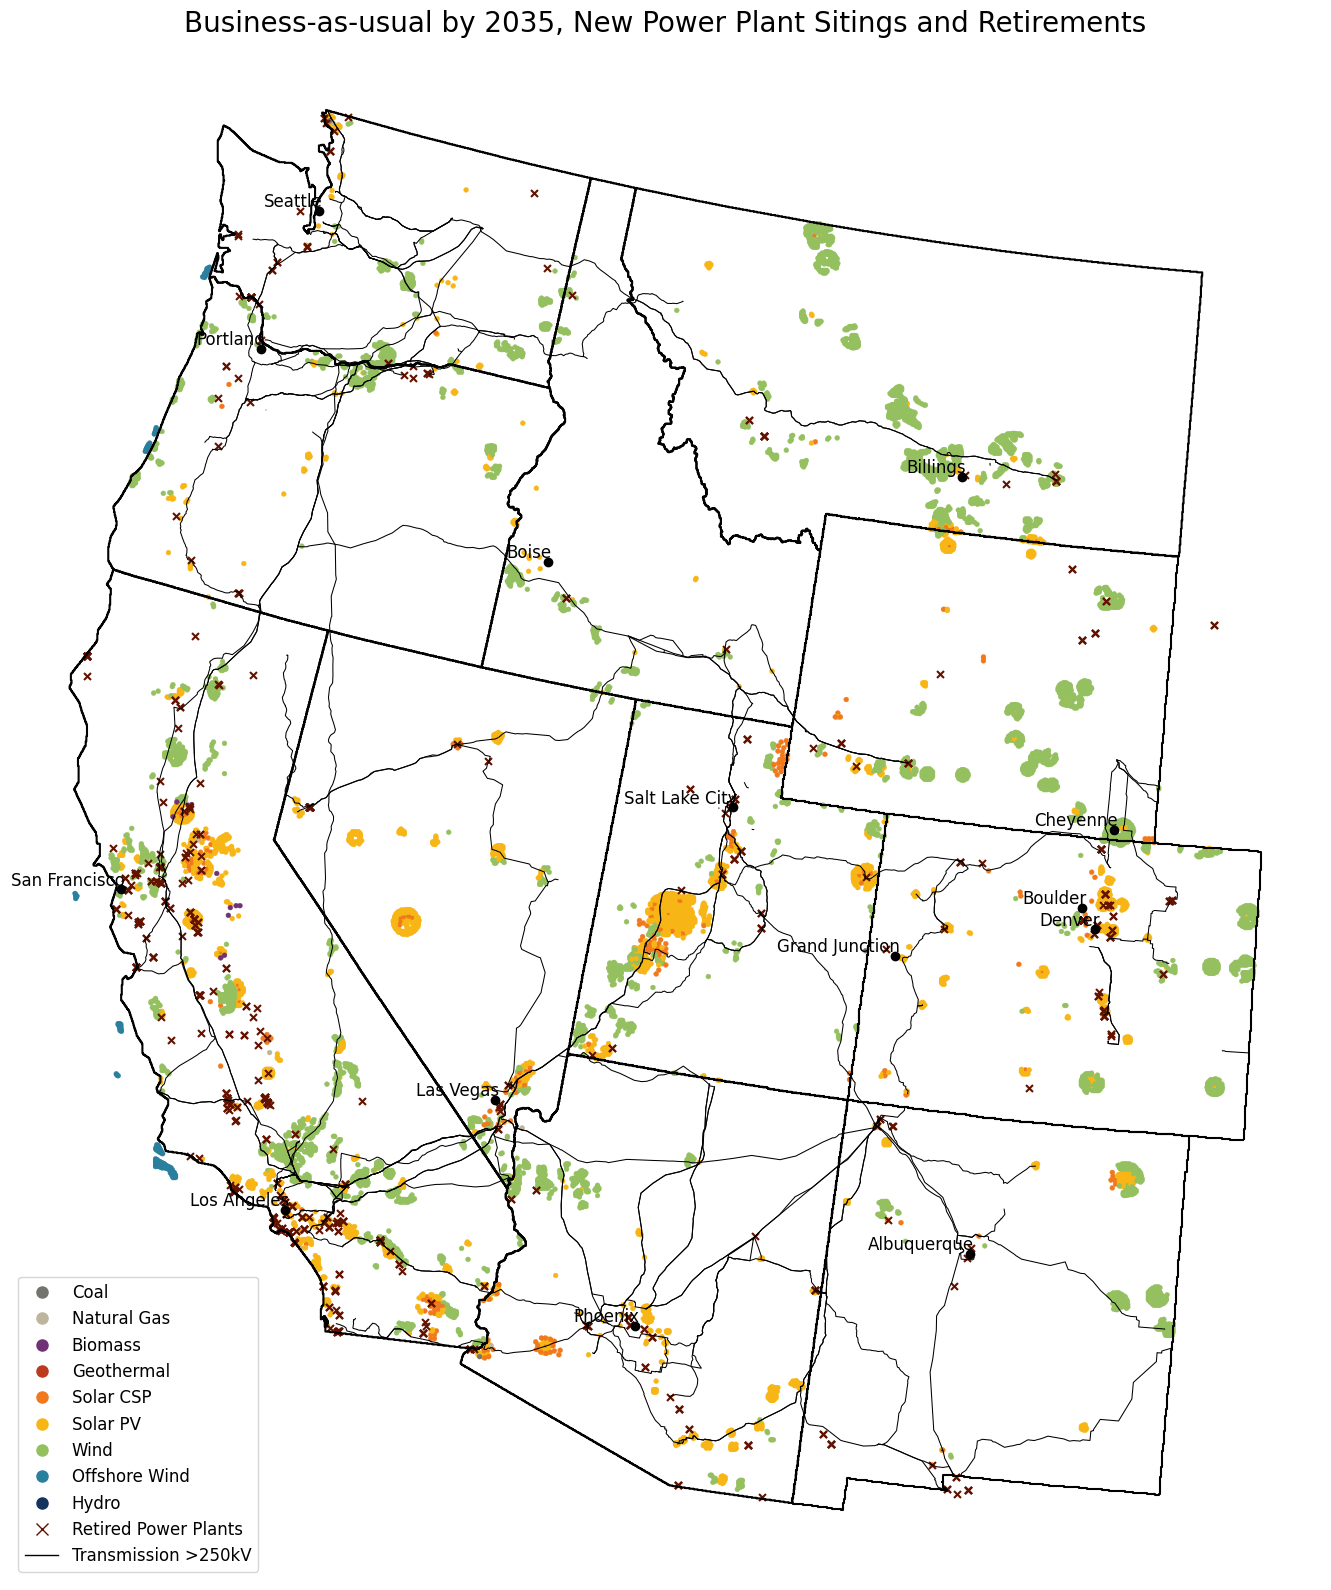

In [123]:
plot_map(gdf=gdf, scenario='business_as_usual_ira_ccs_climate', city_gdf=city_gdf, year=2035,
         output_file_name = 'map_bau_2035.png',
         all_operational=False, 
         title = 'Business-as-usual by 2035, New Power Plant Sitings and Retirements')

#### Business-as-usual by 2035 - All Operational + Retirements

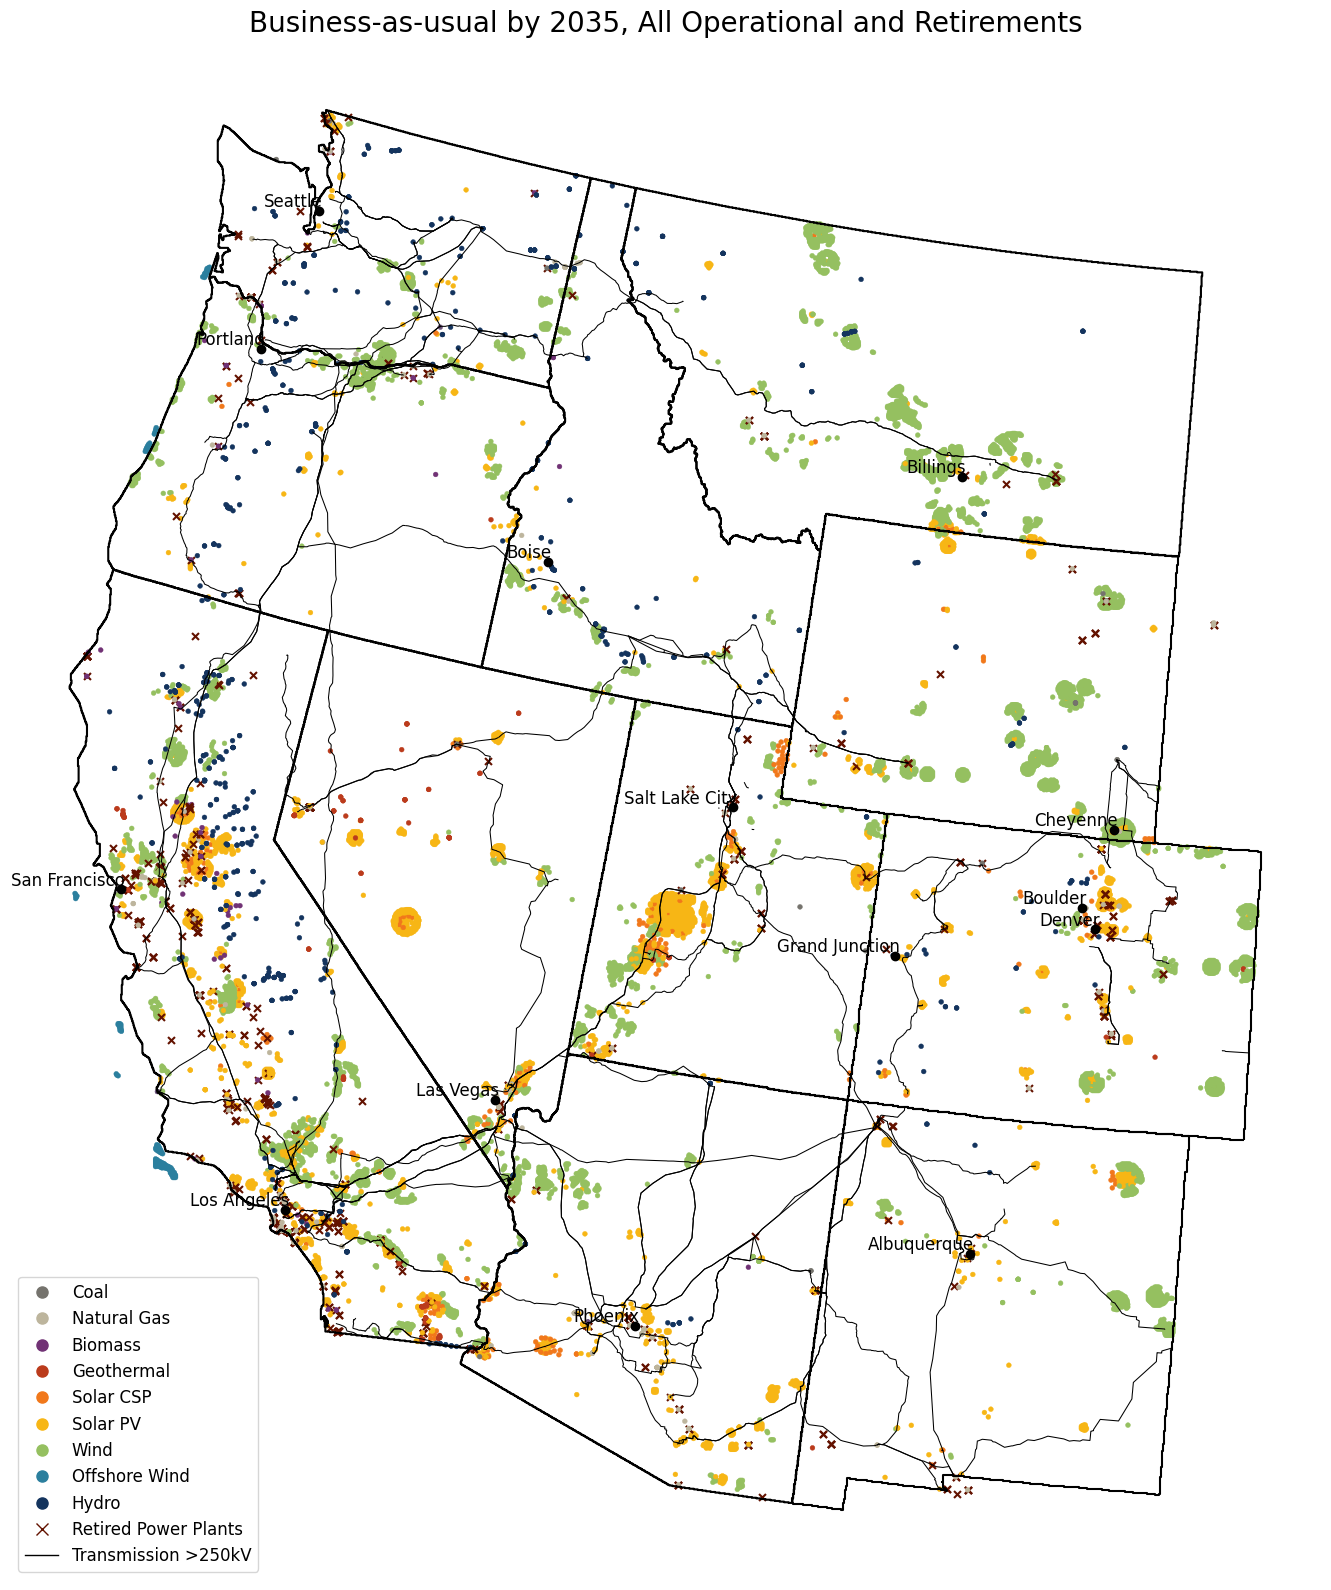

In [121]:
plot_map(gdf=gdf, scenario='business_as_usual_ira_ccs_climate', city_gdf=city_gdf, year=2035,
         output_file_name = 'map_bau_2035_all_operational.png',
         all_operational=True, 
         title = 'Business-as-usual by 2035, All Operational and Retirements')